In [1]:
import numpy as np
from sklearn.manifold import TSNE

# Not open-source but to come
from sndstraj.utils.nomenclatureUtils import get_concepts_labels, CONCEPTS_PATH
from sndstraj.utils.embeddingUtils import concept_proximity

import plotly.graph_objs as go
import plotly

import pandas as pd
import json 
import re
%load_ext autoreload
%autoreload 2

# Create tsne projection and embeddings dataframe for the application

This notebook gives the methods to build the necessary content of the snds2vec explorer. 
The input should be a .json of medical embeddings of the format `Dict['concept_code': 'concept_embedding']` and nomenclature files performing the mapping between the codes and their labels.

Here, we are using the nomenclature in the [sndstraj package](https://gitlab.com/DREES_code/OSAM/cam_gram). 

In [2]:
d = 150
#path2embeddings = '../dash_app/app_data/echantillon_snds2vec_r=30-centered2019-11-19_w2vec_alpha=0.75_k=1_d=150.json'.format(d)
path2embeddings = '../dash_app/app_data/echantillon_mid_grain_r=90-centered2019-12-05_19:11:27.json'
with open(path2embeddings, 'r') as f:
    embeddings_dict = json.load(f)

In [3]:
codes = list(embeddings_dict.keys())
embeddings = list(embeddings_dict.values())
embeddings_mat = np.matrix(embeddings)

### Loads and preprocess codes labels

In [4]:
concepts_labels = get_concepts_labels(codes)
concepts_labels['concept_terminology'].value_counts()

available terminology trees are : dict_keys(['ngap', 'atc7', 'ccam', 'cim10', 'nabm'])
(15968, 3)
1088 concept codes are not found in terminology trees.
71 concepts are found in more than one terminology.
Please rerun this function with verbose >=2 to get back unfound and doublons as second and third results.


cim10      8013
ccam       4547
atc7       1133
unknown    1088
nabm        757
ngap        430
Name: concept_terminology, dtype: int64

In [5]:
color_map = {
    'atc7': 'limegreen', 
    'cim10': 'deepskyblue', 
    'ccam': 'firebrick', 
    'nabm': 'orchid', 
    'ngap': 'yellow', 
    'unknown': 'grey'
}

concepts_labels['plotted_label'] = concepts_labels.apply(lambda x: x['concept_code'] + ' : ' + x['concept_name'], axis=1)#['concept_code']= .to_dict()
concepts_labels['plotted_color'] = concepts_labels['concept_terminology'].map(lambda x: color_map[x]).to_list()

# Reduction de dimension

In [11]:
perplexity = 30
n_iter = 1000
metric='cosine'
tsne = TSNE(
    n_components=2, 
    metric=metric, 
    perplexity=perplexity, 
    early_exaggeration=15, 
    n_iter=n_iter, random_state=2)#n_jobs=40, 
X = tsne.fit_transform(embeddings_mat)

# Visualisation

In [13]:
coordinates = pd.DataFrame({
    'concept_code': codes,
    'x': X[:, 0],
    'y': X[:, 1]
})
plotted_concepts = concepts_labels.merge(
    coordinates, 
    on='concept_code', 
    how='inner')
print(plotted_concepts.shape)
print(concepts_labels.shape)

(15968, 7)
(15968, 5)


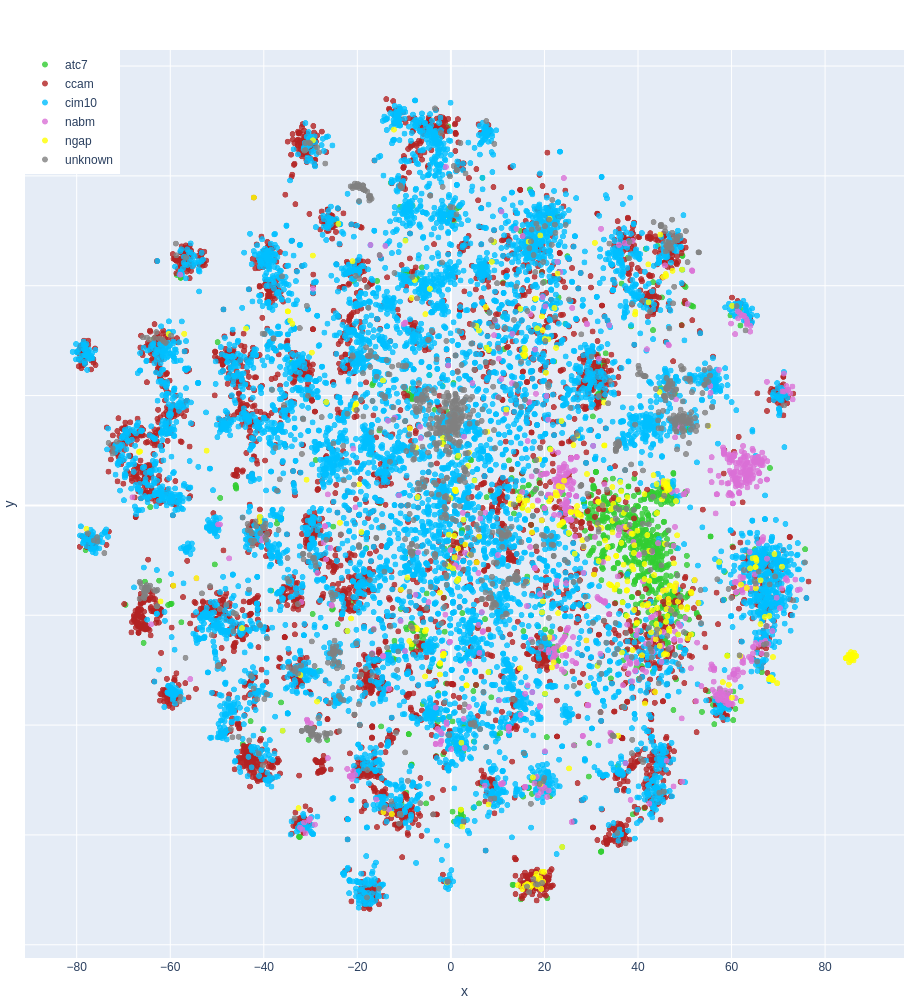

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `snds2vec-midgrain-w90-centered` didn't end with .html. Adding .html to the end of your file.



'snds2vec-midgrain-w90-centered.html'

In [14]:
vocabs = ['atc7', 'ccam', 'cim10', 'nabm', 'ngap', 'unknown']
fig = go.Figure(
    layout=dict(
        #title="{}".format('snds2vec'),
        autosize=True,
        width=1000,
        height=1000,
        xaxis={'title': 'x', 'showticklabels': True},
        yaxis={'title': 'y', 'showticklabels': False},
        margin={'l': 0, 'b': 0, 't': 50, 'r': 0},
        showlegend=True,
        hovermode='closest')
)

for vocab in vocabs:
    vocab_data = plotted_concepts.loc[plotted_concepts['concept_terminology'] == vocab, :]
    fig.add_trace(
        go.Scattergl(
            x=vocab_data['x'],
            y=vocab_data['y'],
            legendgroup="terminology",
            name=vocab,
            text=vocab_data['plotted_label'],
            mode='markers',
            opacity=0.8,
            marker={
                'size': 6,
                'color': vocab_data['plotted_color']
            })
    )

fig.update_layout(legend=dict(x=0, y=1))
config = {'scrollZoom': True}

fig.show(renderer='jupyterlab', config=config)
plotly.offline.plot(fig, filename='{}'.format('snds2vec-midgrain-w90-centered'), config=config)

In [15]:
# save for dash
plotted_concepts.to_csv('../dash_app/app_data/tsne_data_d={}_p={}_niter={}.csv'.format(d, perplexity, n_iter), index=False)

# Build embeddings dataframe taken as input by the distance function

In [16]:
plotted_concepts

concept_code                                       concept_name  \
0              AMI                                   soins infirmiers   
1          PH7/PG7                                      pharmacie 65%   
2              AIS                          actes infirmiers de soins   
3                B  Majoration du tarif pour acte de radiographie ...   
4              AMS                  suivi des actes de kinésithérapie   
...            ...                                                ...   
15963      HFLE002                                            HFLE002   
15964        Z5288                                              Z5288   
15965        P3629                                              P3629   
15966      HBMD056                                            HBMD056   
15967         M70E                                               M70E   

      concept_terminology                                      plotted_label  \
0                    ngap                             AMI : soins infirmiers   
1                    ngap                            PH7/PG7 : pharmacie 65%   
2                    ngap                    AIS : actes infirmiers de soins   
3                    ccam  B : Majoration du tarif pour acte de radiograp...   
4                    ngap            AMS : suivi des actes de kinésithérapie   
...                   ...                                                ...   
15963             unknown                                  HFLE002 : HFLE002   
15964             unknown                                      Z5288 : Z5288   
15965             unknown                                      P3629 : P3629   
15966             unknown                                  HBMD056 : HBMD056   
15967             unknown                                        M70E : M70E   

      plotted_color          x          y  
0            yellow  27.033300  -1.276438  
1            yellow  27.376005  -1.516978  
2            yellow  36.426067   2.567669  
3         firebrick  26.786201  -1.264722  
4            yellow  35.600224 -14.471598  
...             ...        ...        ...  
15963          grey  -2.028458 -21.475548  
15964          grey  -5.424584   4.348793  
15965          grey  20.217299  29.925730  
15966          grey   4.674164  32.890438  
15967          grey  15.000901  26.154264  

[15968 rows x 7 columns]

In [17]:
## Build embeddings dataframe that is taken as input by the distance function
embeddings_df = pd.DataFrame({
    'concept_code': list(embeddings_dict.keys()),
    'concept_embedding': list(embeddings_dict.values())})
embeddings_df = embeddings_df.merge(
    plotted_concepts.loc[:, ['concept_code', 'concept_name', 'concept_terminology']],
    on='concept_code',
    how='inner'
)

In [18]:
embeddings_df.head(5)

concept_code                                  concept_embedding  \
0          AMI  [-4.796992243265885, -1.2772734635021274, -0.8...   
1      PH7/PG7  [-2.0042356652861666, -1.0552736482261864, 0.3...   
2          AIS  [-1.5965144078955193, 0.3650183570165252, -0.2...   
3            B  [-3.5000030643487205, -1.7813175315250787, -1....   
4          AMS  [0.11342643048420897, 0.16395434231928568, -0....   

                                        concept_name concept_terminology  
0                                   soins infirmiers                ngap  
1                                      pharmacie 65%                ngap  
2                          actes infirmiers de soins                ngap  
3  Majoration du tarif pour acte de radiographie ...                ccam  
4                  suivi des actes de kinésithérapie                ngap

Querry one concept

In [21]:
query_code = 'A10AB01'
query_vector = embeddings_dict[query_code]
k=50
target_terminologies = ['cim10']

print('Querrying {} : {}'.format(
    query_code,
    embeddings_df.loc[embeddings_df['concept_code'] == query_code, 'concept_name']))

concept_proximity(
    query_code=query_code,
    embeddings_df=embeddings_df,
    k=k,
    target_terminologies=target_terminologies)

Querrying A10AB01 : 1801    insulin (human)
Name: concept_name, dtype: object


concept_code                                       concept_name  \
2253          E103  diabète sucré de type 1, avec complications oc...   
3031           E10                            diabète sucré de type 1   
4531          Z964                   présence d'implants endocriniens   
993           N083  glomérulopathie au cours du diabète sucré (e10...   
1723          E102  diabète sucré de type 1, avec complications ré...   
1206          H360  rétinopathie diabétique (e10-e14 avec la quatr...   
2538          E112  diabète sucré de type 2, avec complications ré...   
3419          E113  diabète sucré de type 2, avec complications oc...   
5981          Y423  effets indésirables de l'insuline et des hypog...   
4111          E161                               autres hypoglycémies   
8373          E134  autres diabètes sucrés précisés, avec complica...   
2531          E106  diabète sucré de type 1, avec autres complicat...   
2546          E162                       hypoglycémie, sans précision   
8541          E141    diabète sucré, sans précision, avec acidocétose   
1534          G632  polynévrite diabétique (e10-e14 avec le quatri...   
3523          E160             hypoglycémie médicamenteuse, sans coma   
2333          E104  diabète sucré de type 1, avec complications ne...   
5877          E137  autres diabètes sucrés précisés, avec complica...   
741           E109         diabète sucré de type 1, sans complication   
3413          R739                      hyperglycémie, sans précision   
2003          G990  neuropathie du système nerveux autonome au cou...   
6965          E143  diabète sucré, sans précision, avec complicati...   
7135          T383  intoxication par insuline et hypoglycémiants o...   
7701          E136  autres diabètes sucrés précisés, avec autres c...   
3826          E101          diabète sucré de type 1, avec acidocétose   
5847          E100                 diabète sucré de type 1, avec coma   
1072          E107  diabète sucré de type 1, avec complications mu...   
8930          I682  artérite cérébrale au cours d'autres maladies ...   
2960          E114  diabète sucré de type 2, avec complications ne...   
8520          M142  arthropathie diabétique (e10-e14 avec le quatr...   
3145          H280  cataracte diabétique (e10-e14 avec le quatrièm...   
5780          M146                         arthropathie neuropathique   
1092           D16  tumeur bénigne des os et du cartilage articulaire   
1513          E105  diabète sucré de type 1, avec complications va...   
7201          E146  diabète sucré, sans précision, avec autres com...   
5562          H348          autres occlusions vasculaires rétiniennes   
9737          G590  mononévrite diabétique (e10-e14 avec le quatri...   
1598          E117  diabète sucré de type 2, avec complications mu...   
8602          E110                 diabète sucré de type 2, avec coma   
6709          L851  kératose [kératodermie] palmaire et plantaire ...   
3454          E116  diabète sucré de type 2, avec autres complicat...   
3445          E139  autres diabètes sucrés précisés, sans complica...   
7983          Y841  dialyse rénale à l'origine de réactions anorma...   
7115         Z9481                     présence de greffe de pancréas   
4732          E147  diabète sucré, sans précision, avec complicati...   
5145          I152  hypertension secondaire à des atteintes endocr...   
3387          E142  diabète sucré, sans précision, avec complicati...   
10751         E131  autres diabètes sucrés précisés, avec acidocétose   
4381          B488                           autres mycoses précisées   
1168          I120  néphropathie hypertensive, avec insuffisance r...   

      concept_terminology  distance2query  
2253                cim10        0.590985  
3031                cim10        0.562833  
4531                cim10        0.554939  
993                 cim10        0.533227  
1723                cim10        0.515151  
1206              

Save for the app

In [22]:
embeddings_df.drop('concept_embedding', axis=1).to_csv('../dash_app/app_data/concept_infos.csv', index=False)

In [37]:
path2embedding_dict = '../dash_app/app_data/echantillon_mid_grain_r=90-centered2019-12-05_19:11:27.json'
path2concept_infos = '../dash_app/app_data/concept_infos.csv'
path2tsne_data = '../dash_app/app_data/tsne_data_d=150_p=30_niter=1000.csv'
path2explanations = '../dash_app/app_data/explanations.md'
DL_DIRECTORY = '../dash_app/app_data'

# tsne_paramaters to display
rex = re.search('d=(\d\d*)_p=(\d\d*)_niter=(\d\d*).csv$', path2tsne_data)
embedding_dimension = rex.group(1)
perplexity = rex.group(2)
niter = rex.group(3)

#  reading data
with open(path2embedding_dict, 'r') as f:
    embeddings_dict = json.load(f)

with open(path2explanations, 'r') as f:
    explanation_markdown = f.read()

tsne_data = pd.read_csv(path2tsne_data)
embedding_df = pd.read_csv(path2concept_infos).dropna()

embedding_df['concept_embedding'] = embedding_df['concept_code'].map(lambda x: embeddings_dict[x])

In [35]:
embedding_df.loc[embedding_df['concept_code'].isna(), :]

concept_code concept_name concept_terminology
11174          NaN          NaN             unknown